<a href="https://colab.research.google.com/github/visiont3lab/flask-static-website/blob/master/regressione_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/visiont3lab/flask-static-website/blob/master/regressione_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressione: Come Scegliere il modello

Questo notebook fornisce un esempio  che permette di comparare il comportamento di diversi regressori e scegliere il migliore. Al fine di fare questa scelta viene utilizzata la cross-validation che permette di capire quanto il regressore è robusto a variazioni nel train-test set.


1. Caricare il dataset (di regressione). 
2. Comparare i modelli
3. Scegliere il modello migliore
4. Applicare il modello allenato a un nuovo set di dati

## Importare le librerie

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error  # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import median_absolute_error # MedAE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RANSACRegressor, SGDRegressor, HuberRegressor, TheilSenRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import plotly.graph_objects as go
import pickle
import json
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn import datasets
from google.colab import data_table
import seaborn as sns
import plotly.express as px

## 1. Caricare il dataset
Assumiamo che l'ultima colonna del dataset sia il valore di target e che il dataset contenga come input solo valori numerici.

In [ ]:
def load_dataset(name="boston"):
    datasets_list = ["boston", "diabetes"] #,"tips"]
    chosen_dataset = name #"boston"

    boston = datasets.load_boston()
    df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
    df_boston["price"] = boston.target

    diabetes = datasets.load_diabetes()
    df_diabetes = pd.DataFrame(diabetes.data,columns=diabetes.feature_names)
    df_diabetes["desease"] = diabetes.target
    df_diabetes = df_diabetes.round(decimals=5)

    #df_nuovo_dataset = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSqHhx2kS9gCNmI04yksqTP2PRsT6ifTU2DLokKs3Y6KgcSGIAL7_4t_q_8kNhVkFA0xD2nt7hn_w-5/pub?output=csv")

    dict_datasets = {
        "boston": df_boston,
        "diabetes": df_diabetes,
    #    "nuovo" : df_nuovo_dataset
    }    
    df = dict_datasets[chosen_dataset]#.head(10)
    df = df.dropna()

    #print(df.head())
    X = df.iloc[:,0:-1].values  # Input: dalla prima alla penultima colonna
    Y = df.iloc[:,-1].values    # Target: utlima colonna

    return X,Y,df

In [ ]:
X,Y,df = load_dataset(name="boston")
display( data_table.DataTable(df, include_index=False, num_rows_per_page=10) )

#scale = StandardScaler()
#X = scale.fit_transform(X)
#display(df.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


### 1.1 Analisi dei dati

In [ ]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
# Conversion to tidy format
dict_new = {}
numerical_data = []
observation = []
for name in df.keys():
    numerical_data=numerical_data + df[name].values.tolist()
    observation=observation+[name for i in range(0,len(df[name].values))]

dict_new["numerical_data"] = numerical_data
dict_new["observation"] = observation

df_new = pd.DataFrame(dict_new)
data_table.DataTable(df_new, include_index=False, num_rows_per_page=10)

,numerical_data,observation
0,0.00632,CRIM
1,0.02731,CRIM
2,0.02729,CRIM
3,0.03237,CRIM
4,0.06905,CRIM
...,...,...
7079,22.40000,price
7080,20.60000,price
7081,23.90000,price
7082,22.00000,price


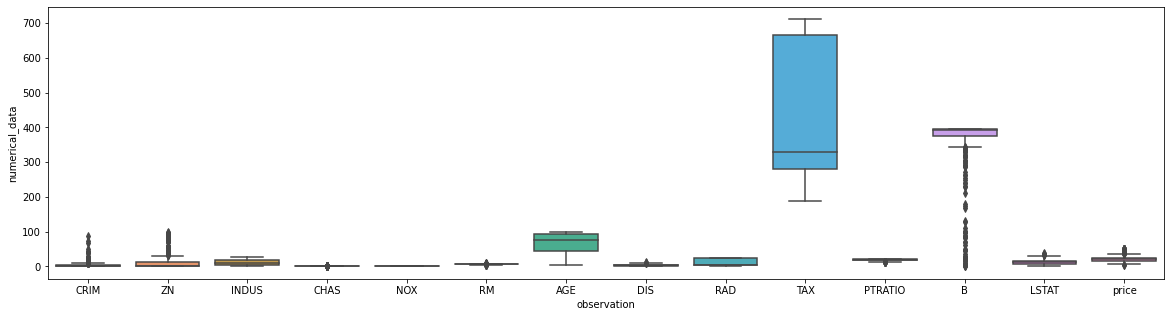

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="observation", y="numerical_data", data=df_new)

In [ ]:
# https://plotly.com/python/plotly-express/
# Apply standard scaler for better visualization
#fig = px.scatter(df_new, x="observation", y="numerical_data")
fig = px.box(df_new, x="observation", y="numerical_data", points="all", notched=True)
#fig = px.violin(df_new, y="numerical_data", x="observation") #, box=True, points="all") #, hover_data=df_new.columns)
fig.show()

## 1.2 Influenza degli inputs sul target basandoci su un modello allenato

Training Score:  0.98
Validation Score:  0.86
Features sorted by their score:
[(0.418, 'LSTAT'), (0.4052, 'RM'), (0.0581, 'DIS'), (0.0293, 'CRIM'), (0.0193, 'PTRATIO'), (0.0161, 'AGE'), (0.013, 'B'), (0.0127, 'TAX'), (0.0105, 'NOX'), (0.0076, 'INDUS'), (0.0047, 'ZN'), (0.0046, 'RAD'), (0.0011, 'CHAS')]


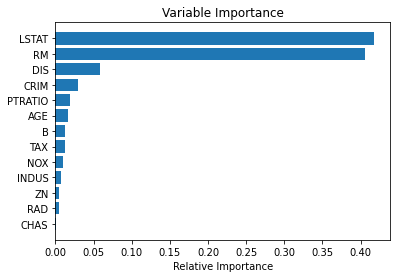

In [ ]:

# Isolate Data, class labels and column values
X,Y,df = load_dataset(name="boston")
names = df.columns.values

# Build the model
rfc = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

# Fit the model
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
rfc.fit(X_train, Y_train)
print("Training Score: " , np.round(rfc.score(X_train, Y_train),2))
print("Validation Score: " , np.round(rfc.score(X_test, Y_test),2))

# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))

# Isolate feature importances 
importance = rfc.feature_importances_

# Sort the feature importances 
sorted_importances = np.argsort(importance)

# Insert padding
padding = np.arange(len(names)-1) + 0.5

# Plot the data
plt.barh(padding, importance[sorted_importances], align='center')

# Customize the plot
plt.yticks(padding, names[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

# Show the plot
plt.show()

## 2. Comparare i modelli

In [ ]:
def validate(Y_test,Y_pred,name):
    mse = mean_squared_error(Y_test,Y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test,Y_pred)
    medae = median_absolute_error(Y_test,Y_pred)
    print("[" + name + "]" + " MSE: ", round(mse,4), "RMSE  : ", round(rmse,4), "MAE: ", round(mae,4), "MedAE: ", round(medae,4))

def compare_models(X,Y):
    # Split data into training and validation set
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01,  shuffle=True, random_state=0) 
    #print("Shapes: X_train: ", X_train.shape, "Y_train: ", Y_train.shape, "X_test: ", X_test.shape, "Y_test", Y_test.shape)
    #print("Metric : negative mean square error (MSE)")

    # Scaling
    sc = StandardScaler()
    sc.fit(X)
    X_train = sc.transform(X)
    Y_train = Y
    #X_test = sc.transform(X_test)

    # PCA
    '''
    pc = PCA(n_components=0.95)
    pc.fit(X_train)
    X_train = pc.transform(X_train)
    X_test = pc.transform(X_test)
    print (pc.explained_variance_)
    print (pc.explained_variance_ratio_)
    '''
    # Polinomial degree
    '''
    poly = PolynomialFeatures(degree=2)
    poly.fit(X_train)
    X_train = poly.transform(X_train)
    X_test = poly.transform(X_test)
    '''

    # user variables to tune
    seed    = 5
    folds   = 5 # 10 = 10%, 5 = 20% for testing
    #5-fold cross validation. This means that 20% of the data is used for testing, this is usually pretty accurate.
    metric  = "neg_mean_squared_error"

    # hold different regression models in a single dictionary
    models = {}
    models["Linear"]        = LinearRegression()
    #models["RANSAC"]        = RANSACRegressor()
    models["Huber"]         = HuberRegressor(max_iter=1000)
    models["TheilSen"]      = TheilSenRegressor()
    #models["SGD"]           = SGDRegressor(max_iter=500,penalty=None, eta0=0.01, tol=0.00001)
    models["Ridge"]         = Ridge()
    models["Lasso"]         = Lasso()
    models["ElasticNet"]    = ElasticNet()
    models["KNN"]           = KNeighborsRegressor(n_neighbors=5)
    models["DecisionTree"]  = DecisionTreeRegressor()
    models["SVR"]           = SVR(gamma="auto")
    models["AdaBoost"]      = AdaBoostRegressor(n_estimators=50)
    models["GradientBoost"] = GradientBoostingRegressor(n_estimators=100)
    models["RandomForest"]  = RandomForestRegressor(n_estimators=100)
    models["ExtraTrees"]    = ExtraTreesRegressor(n_estimators=100)

    # 10-fold cross validation for each model
    model_results = []
    model_names   = []
    for model_name in models:
        model   = models[model_name]
        k_fold  = KFold(n_splits=folds, random_state=seed,shuffle=True)
        results = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring=metric)

        model_results.append(results)
        model_names.append(model_name)
        print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

    fig = go.Figure()
    for name,res in zip(model_names,model_results):    
        fig.add_trace(go.Box(y=res,name=name, boxpoints='all'))
    #fig.show()
    return fig

In [ ]:
fig_compare_models = compare_models(X,Y)
fig_compare_models.show()

Linear: -25.048, 8.456
Huber: -25.894, 11.434
TheilSen: -38.368, 23.267
Ridge: -25.02, 8.527
Lasso: -30.279, 10.937
ElasticNet: -31.508, 12.118
KNN: -21.996, 7.246
DecisionTree: -27.473, 11.629
SVR: -29.949, 12.772
AdaBoost: -14.455, 1.762
GradientBoost: -9.041, 2.071
RandomForest: -11.213, 2.515
ExtraTrees: -10.071, 1.627


## 3. Scegliere il modello migliore

In [ ]:
def plot_fig(Ys, names):
    # Ys list of output to plot [Y_real, Y_pred]
    n = np.linspace(0,len(Ys[0]), len(Ys[0]), dtype=int)
    fig = go.Figure()
    for yh,nm in zip(Ys,names):
        fig.add_trace(go.Scatter(x=n, y=yh,
                      mode='lines',#mode='lines+markers',
                      name=nm))
    fig.update_layout(
      hovermode = "x",
      paper_bgcolor = "rgb(0,0,0)" ,
      plot_bgcolor = "rgb(10,10,10)" , 
      title=dict(
          x = 0.5,
          text = "Risultati",
          font=dict(
              size = 20,
              color = "rgb(255,255,255)"
          )
      )
    )
    return fig

def trainBest(X,Y,selected="Linear", modelName='best_model.sav'):
    max_val = -10000000
    n_iter = 20
    R2_train_max = 0
    R2_test_max = 0
    for i in range(0,n_iter):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10,  shuffle=True) 

        # Scaling
        #sc = StandardScaler()
        #sc.fit(X_train)
        #X_train = sc.transform(X_train)
        #X_test = sc.transform(X_test)

        # create and fit the best regression model
        seed =5
        models = {}
        models["Linear"]        = LinearRegression()
        #models["RANSAC"]        = RANSACRegressor()
        models["Huber"]         = HuberRegressor(max_iter=1000)
        models["TheilSen"]      = TheilSenRegressor()
        #models["SGD"]           = SGDRegressor(max_iter=500,penalty=None, eta0=0.01, tol=0.00001)
        models["Ridge"]         = Ridge()
        models["Lasso"]         = Lasso()
        models["ElasticNet"]    = ElasticNet()
        models["KNN"]           = KNeighborsRegressor()
        models["DecisionTree"]  = DecisionTreeRegressor()
        models["SVR"]           = SVR()
        models["AdaBoost"]      = AdaBoostRegressor()
        models["GradientBoost"] = GradientBoostingRegressor()
        models["RandomForest"]  = RandomForestRegressor()
        models["ExtraTrees"]    = ExtraTreesRegressor()
        
        best_model = models[selected]

        # Logistic Regression
        pipeline = Pipeline([
            ("sc", StandardScaler()),
            #("pca", PCA(n_components=0.98)),
            ("reg", best_model),
        ])
        pipeline.fit(X_train, Y_train)
        
        #best_model.fit(X_train, Y_train)

        # make predictions using the model (train and test)
        Y_test_pred = pipeline.predict(X_test)
        Y_train_pred = pipeline.predict(X_train)
        #print("[INFO] MSE : {}".format(round(mean_squared_error(Y_test, Y_test_pred), 3)))

        # R2 score coefficient of determination (quanto gli input influscono sulla predizione)
        # 0 male 1 bene
        #validate(Y_train,Y_train_pred,name="Training")
        R2_train = pipeline.score(X_train, Y_train)
        #print("[Training] R2 Score: ", round(R2_train,3))

        #validate(Y_test,Y_test_pred,name="Test")
        R2_test = pipeline.score(X_test, Y_test)
        #print("[Test] R2 Score: ", round(R2_test,3))

        if np.abs(R2_test)>max_val:
            # Save model
            R2_train_max = R2_train
            R2_test_max = R2_test
            pickle.dump(pipeline, open(modelName, 'wb'))
            max_val = np.abs(R2_test)
            fig_train = plot_fig([Y_train,Y_train_pred],["Train Real", "Train Predicted"])
            fig_test = plot_fig([Y_test,Y_test_pred],["Test Real","Test Predicted"])
    
    print( "Best: [Training] R2 Score: ", round(R2_train_max,3))
    print("Best: [Test] R2 Score: ", round(R2_test_max,3))
    return fig_train,fig_test

def train(X,Y,selected="Linear", modelName='best_model.sav'):

    # create and fit the best regression model
    seed =5
    models = {}
    models["Linear"]        = LinearRegression()
    #models["RANSAC"]        = RANSACRegressor()
    models["Huber"]         = HuberRegressor(max_iter=1000)
    models["TheilSen"]      = TheilSenRegressor()
    #models["SGD"]           = SGDRegressor(max_iter=500,penalty=None, eta0=0.01, tol=0.00001)
    models["Ridge"]         = Ridge()
    models["Lasso"]         = Lasso()
    models["ElasticNet"]    = ElasticNet()
    models["KNN"]           = KNeighborsRegressor()
    models["DecisionTree"]  = DecisionTreeRegressor()
    models["SVR"]           = SVR()
    models["AdaBoost"]      = AdaBoostRegressor()
    models["GradientBoost"] = GradientBoostingRegressor()
    models["RandomForest"]  = RandomForestRegressor()
    models["ExtraTrees"]    = ExtraTreesRegressor()
    
    best_model = models[selected]

    # Logistic Regression
    pipeline = Pipeline([
        ("sc", StandardScaler()),
        #("pca", PCA(n_components=0.98)),
        ("reg", best_model),
    ])
    pipeline.fit(X, Y)
    
    #best_model.fit(X_train, Y_train)
    # make predictions using the model (train and test)
    Y_pred = pipeline.predict(X)
    #print("[INFO] MSE : {}".format(round(mean_squared_error(Y_test, Y_test_pred), 3)))

    # R2 score coefficient of determination (quanto gli input influscono sulla predizione)
    # 0 male 1 bene
    #validate(Y_train,Y_train_pred,name="Training")
    R2 = pipeline.score(X, Y)
    #print("[Training] R2 Score: ", round(R2_train,3))

    pickle.dump(pipeline, open(modelName, 'wb'))

    fig = plot_fig([Y,Y_pred],["Train Real", "Train Predicted"])
    
    print( "R2 Score: ", round(R2,3))
    return fig

In [ ]:
model_list = ["Linear", "Huber", "TheilSen","Ridge","Lasso","ElasticNet","KNN","DecisionTree","SVR","AdaBoost","GradientBoost","RandomForest","ExtraTrees"]
chosen_model = "GradientBoost"
#fig_train, fig_test = train(X,Y,selected=chosen_model,modelName="test.sav")
fig = train(X,Y,selected=chosen_model,modelName="test.sav")
fig.show()

R2 Score:  0.976


## 4. Applicare il modello allenato a un nuovo set di dati

In [ ]:
def apply_model(X,modelName='best_model.sav'):
    loaded_model = pickle.load(open(modelName, 'rb'))
    y_hat = loaded_model.predict(X)
    return y_hat

Per questa parte fingeremo di avere nuovi dati. Questi ultimi li creeremo utilizzando la funzione **train_test_split** di scikit-learn.

In [ ]:
# Creiamo dei dati
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80,  shuffle=True) 

Carichiamo la pipeline componente per componente per componente

In [ ]:
loaded_model = pickle.load(open("test.sav", 'rb'))

In [ ]:
sc_block = loaded_model.named_steps["sc"]

In [ ]:
loaded_model = pickle.load(open("test.sav", 'rb'))

# Applicare lo Standard Scaling
sc_block = loaded_model.named_steps["sc"]
X_test_sc = sc_block.transform(X_test)

# Applicare la PCA
#pca_block = loaded_model.named_steps["pca"]
#X_test_pca = pca_block.transform(X_test_sc)
#print(pca_block.explained_variance_ratio_)

# Applicare il regressore
model_trained = loaded_model.named_steps["reg"]
Y_pred = model_trained.predict(X_test_sc)

Carichiamo l'intera pipeline

In [ ]:
Y_pred_pipe = apply_model(X_test,modelName="test.sav")

Assicuriamoci che i due risultati siano uguali

In [ ]:
fig_res = plot_fig([Y_test, Y_pred,Y_pred_pipe], ["test", "pred","pipe"])
fig_res.show()

## Extra: Train-Test procedure

In [ ]:
# Procedura di training
def train_procedure():
    # 0 CARICA DATASET
    print("CARICA DATASET")
    X,Y,df = load_dataset(name="boston")

    # 1 COMPARA I MODELLI
    print("COMPARA MODELLI")
    fig_compare_models = compare_models(X,Y)

    # 2 SCELGO IL MODELLO MIGLIORE
    print("SCELGO MODELLO MIGLIORE")
    model_list = ["Linear", "Huber", "TheilSen","Ridge","Lasso","ElasticNet","KNN","DecisionTree","SVR","AdaBoost","GradientBoost","RandomForest","ExtraTrees"]
    chosen_model = "GradientBoost"
    model_name = "test.sav"
    fig_train, fig_test = train(X,Y,selected=chosen_model,modelName=model_name)

# Procedura di test
def test_procedure():
    # 3 CARICO IL NUOVO DATASET
    print("CARICO NUOVO DATASET")
    X,Y,df = load_dataset(name="boston")
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80,  shuffle=True) 

    # 3bis. APPLICARE IL MODELL ALLENATO
    print("APPLICO MODELLO ALLENATO")
    Y_pred_pipe = apply_model(X_test,modelName="test.sav")
    fig_res = plot_fig([Y_test,Y_pred_pipe], ["test","pipe"])

In [ ]:
#train_procedure()
test_procedure()